In [1]:
import os.path as op

from tqdm.notebook import tqdm
from multiprocessing import Pool
from functools import partial

import matplotlib.pyplot as plt

import numpy as np
from scipy.io import loadmat
from scipy.signal import spectrogram
from scipy.stats import ttest_ind, linregress

from neurodsp.filt import filter_signal
from neurodsp.spectral import compute_spectrum
from neurodsp.utils.norm import normalize_sig

from fooof import FOOOFGroup, FOOOF

from timescales.est.psd import fit_psd, convert_knee_val
from timescales.est.acf import fit_acf, compute_acf, exp_decay_func

### Sliding Window Tau

#### Background
This notebook uses fcx-1, from CRCNS, to investigate sliding window tau estimation. This data consists of two cycles, each with ~7 minutes of wake followed by ~20 minutes of sleep. Based on Watson at al. 2016, they show that overall power increases, corresponding to low variance voltage segments, are associated with non-REM episodes. CRCNS provides times of sleep, non-rem, rem, and micro-arousals. Here, we focus on comparing timescales between sleep vs non-rem, since rem and micro arousals periods contain much less data.


#### Method / Results
For the ~54 minutes of interest, a window is slide across the data, with a step size of 1s. Each window contains 5s before and 5s after the current sample. Windows are grouped by wake and non-REM sleep periods. A PSD is computed for each window, and a timescale is determined. The results show that short timescales are associate with non-REM periods and long timescales are associated with wake periods.

#### Discussion
The wake periods tend to have short timescales, but also have lower r-squared values, compared to the non-REM periods. This may mean that there is more noise during the wake periods (i.e. noise from movement) and/or that the Lorenztian isn't the appriopriate model.

Many of the wake timescales appear to be > 1s long (< 1 Hz) and Welch's doesn't provide resolution below 1 Hz which may be something to also consider.

#### Reference
Network Homeostasis and State Dynamics of Neocortical Sleep. Watson BO, Levenstein D, Greene JP, Gelinas JN, Buzsáki G.; Neuron. 2016 Apr 27. pii: S0896-6273(16)30056-3. doi: 10.1016/j.neuron.2016.03.036

In [2]:
data_dir = '/home/rph/Projects/timescale-methods/data_unpack/20140526_277um'
data_mat_dir = '/home/rph/Projects/timescale-methods/fcx1/data_mats'

In [3]:
# Load LFP
fs = 1250

lfp_file = op.join(data_mat_dir, 'data18.mat')

sig_lfp = loadmat(lfp_file)['data'][0]
sig_lfp = normalize_sig(sig_lfp, mean=0, variance=1)
#sig_lfp = filter_signal(sig_lfp, fs, 'lowpass', 200)
times = np.arange(0, len(sig_lfp)/fs, 1/fs)

# Extract behavioral data
beh_file = '/home/rph/Projects/timescale-methods/fcx1/data_mats/20140526_277um_WSRestrictedIntervals.mat'

beh = loadmat(beh_file)

nrem = beh['SWSPacketTimePairFormat'].astype(int) * fs
wake = beh['WakeTimePairFormat'].astype(int) * fs
rem = beh['REMTimePairFormat'].astype(int) * fs

In [4]:
# Functions

def create_windows(start, end, win_len, win_spacing):
    # Determine windows
    sig_len = end - start

    win_starts = np.arange(start-win_len//2, end+win_len//2, win_spacing)

    mids = win_starts + (win_len//2)
    
    return win_starts, mids


def sort_taus(sig_lfp, rem, nrem, wake, mids, taus, rsq):
    
    # Sort taus by type
    labels = np.zeros_like(sig_lfp)

    for periods, lab in zip([rem, nrem, wake], [1, 2, 3]):
        for i in periods:
            labels[int(i[0]):int(i[1])] = lab

    rem_inds = np.where(labels==1)[0]
    nrem_inds = np.where(labels==2)[0]
    wake_inds = np.where(labels==3)[0]

    rem_taus = []
    nrem_taus = []
    wake_taus = []

    rem_rsq = []
    nrem_rsq = []
    wake_rsq = []

    for l, t, r in zip(labels[mids], taus, rsq):
        if l == 1:
            rem_taus.append(t)
            rem_rsq.append(r)
        elif l == 2:
            nrem_taus.append(t)
            nrem_rsq.append(r)
        elif l == 3:
            wake_taus.append(t)
            wake_rsq.append(r)

    rem_taus = np.array(rem_taus)
    nrem_taus = np.array(nrem_taus)
    wake_taus = np.array(wake_taus)
    
    return (wake_taus, rem_taus, nrem_taus), (wake_rsq, rem_rsq, nrem_rsq) 


def _fit_psd(s, sig_lfp=None, fs=None, win_len=None, compute_spectrum_kwargs=None,
              f_range=None, knee_bounds=None, fooof_init=None):
    
    if compute_spectrum_kwargs is None:
        compute_spectrum_kwargs = {}
        
    freqs, powers = compute_spectrum(sig_lfp[s:s+win_len], fs, f_range=f_range,
                                     **compute_spectrum_kwargs)
    
    if fooof_init is None:
        fooof_init = dict(max_n_peaks=5, peak_threshold=2.5,
                          peak_width_limits=(2, 12))
    
    fm, _, kt = fit_psd(freqs, powers, f_range, fooof_init=fooof_init,
                        knee_bounds=knee_bounds, n_jobs=1)
    
    rsq = fm.r_squared_
    
    return kt, rsq, fm


def _fit_acf(s, sig_lfp=None, fs=None, win_len=None):
    
    corrs = compute_acf(sig_lfp[s:s+win_len], fs)
    
    params = fit_acf(corrs, fs)
    
    corrs_fit = exp_decay_func(np.arange(1, len(corrs)+1), fs, *params)
    
    _, _, rsq, _, _ = linregress(corrs, corrs_fit)
    
    return params[0], rsq


def plot_tau_dist(wake_taus, nrem_taus, rescale_y=False, xlim=None, title=None):
    
    if rescale_y:
        fig, axes = plt.subplots(nrows=2, figsize=(10, 7.5))
        ax0 = axes[0]
    else:
        fig, axes = plt.subplots(nrows=1, figsize=(10, 7.5/2))
        ax0 = axes
      
    bins = np.histogram(np.hstack((wake_taus, nrem_taus)), bins=200)[1]
    
    ax0.hist(wake_taus, bins, alpha=.5, color='C0', label='Wake')
    ax0.hist(nrem_taus, bins, alpha=.5, color='C1', label='Non-REM')
    
    if title is None:
        ax0.set_title('Wake vs Non-REM Taus Distributions')
    
    if xlim is not None:
        ax0.set_xlim(xlim)
    
    
    if rescale_y:
        
        _wake_taus = wake_taus[np.where(wake_taus < np.max(nrem_taus))[0]]
        bins = np.histogram(np.hstack((_wake_taus, nrem_taus)), bins=200)[1]
        bins = np.histogram(np.hstack((_wake_taus, nrem_taus)), bins=200)[1]
    
        axes[1].hist(_wake_taus, bins, alpha=.5, color='C0', label='Wake')
        axes[1].hist(nrem_taus, bins, alpha=.5,color='C1', label='Non-REM')
        axes[1].set_xlabel('Tau')
        
            
        if xlim is not None:
            axes[1].set_xlim(xlim)

    if title is not None:
        ax0.set_title(title)
        
    plt.legend();
    
    
def plot_rsq_dist(wake_rsq, nrem_rsq, title=None, nbins=200):
    
    fig, axes = plt.subplots(figsize=(10, 7.5/2))
    
    title = 'R-Squared Distribution' if title is None else title
    plt.title(title)

    bins = np.histogram(np.hstack((wake_rsq, nrem_rsq)), bins=nbins)[1]
    plt.hist(wake_rsq, alpha=.5, bins=bins, color='C0', label='Wake')
    plt.hist(nrem_rsq, alpha=.5, bins=bins, color='C1', label='Non-REM');
    plt.legend();
    
    
def plot_connected_scatter(taus_a, taus_b, ax, title, ylim=None, ylabel=None):
    
    xs_a = np.random.uniform(1, 1.2, size=len(taus_a))
    ax.scatter(xs_a, taus_a, alpha=.5)


    xs_b = np.random.uniform(1.8, 2, size=len(taus_b))
    ax.scatter(xs_b, taus_b, alpha=.5)

    vp = ax.violinplot([taus_a, taus_b], showextrema=False)
    vp['bodies'][1].set_color('C1')
    vp['bodies'][1].set_facecolor('C1')
    vp['bodies'][1].set_edgecolor('C1')

    b = vp['bodies'][0]
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], -np.inf,
                                              np.mean(b.get_paths()[0].vertices[:, 0]))

    b = vp['bodies'][1]
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0],
                                              np.mean(b.get_paths()[0].vertices[:, 0]), np.inf)

    for i, (t_psd, t_acf) in enumerate(zip(taus_a, taus_b)):
        ax.plot([xs_a[i], xs_b[i]], [t_psd, t_acf], color='k', alpha=.1)
    
    ax.set_title(title)  
    ax.set_ylabel('Tau')
    ax.set_xticks([1, 2])
    ax.set_xticklabels(['PSD', 'ACF'])
    ax.set_xlim(0, 3)
    
    if ylabel is None:
        ax.set_ylabel('Tau')
    else:
        ax.set_ylabel(ylabel)
        
    if ylim is not None:
        ax.set_ylim(ylim)

### SpecParam

In [5]:
start_ends = [nrem[0][0], nrem[-1][-1], rem[0][0],
              rem[-1][-1], wake[0][0], wake[-1][-1]]

start = min(start_ends)-1
end = max(start_ends)

fs = 1250

win_len = int(20*fs)+1
win_spacing = int(fs * 10)

win_starts, mids = create_windows(start, end, win_len, win_spacing)

In [6]:
# SpecParam
f_range = (0, 80)

knee_freqs = np.zeros(len(win_starts))
knee_taus = np.zeros(len(win_starts))

fit_kwargs = dict(
    sig_lfp=sig_lfp, fs=fs, win_len=win_len, f_range=f_range,
    compute_spectrum_kwargs=dict(nperseg=int(2*fs), avg_type='mean'),
    knee_bounds=(.05, 100000)
)

with Pool(processes=8) as pool:
    
    mapping = pool.imap(partial(_fit_psd, **fit_kwargs), win_starts, chunksize=20)
    
    results = list(tqdm(mapping, total=len(win_starts), dynamic_ncols=True))

  0%|          | 0/616 [00:00<?, ?it/s]

In [7]:
# Unpack results
taus = np.array([i[0] for i in results])
rsq = np.array([i[1] for i in results])
fms = [i[2] for i in results]

_taus, _rsqs = sort_taus(sig_lfp, rem, nrem, wake, mids, taus, rsq)

wake_taus, rem_taus, nrem_taus = _taus
wake_rsq, rem_rsq, nrem_rsq = _rsqs

### Results

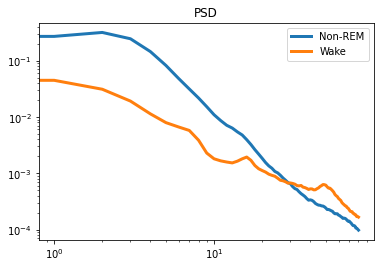

In [8]:
f_range = (0, 80)

powers_wake = np.zeros((len(wake), 81))
powers_nrem = np.zeros((len(nrem), 81))

for i, p in enumerate(nrem):
    _sig = sig_lfp[p[0]-1:p[1]]
    freqs, p = compute_spectrum(_sig, fs, f_range=f_range)
    powers_nrem[i] = p
    
for i, p in enumerate(wake):
    _sig = sig_lfp[p[0]-1:p[1]]
    freqs, p = compute_spectrum(_sig, fs, f_range=f_range)
    powers_wake[i] = p

plt.loglog(freqs, powers_nrem.mean(axis=0), lw=3, color='C0', label='Non-REM')
plt.loglog(freqs, powers_wake.mean(axis=0), lw=3, color='C1', label='Wake')
plt.title('PSD')
plt.legend();

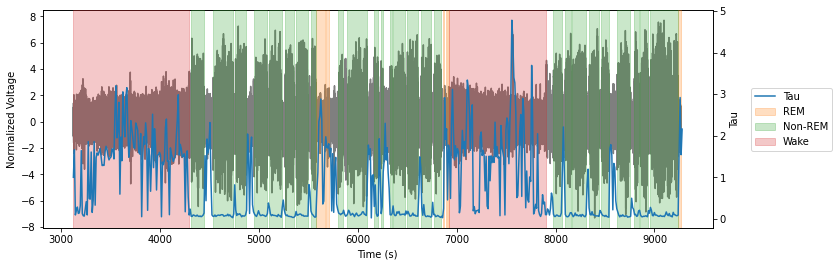

In [9]:
fig, ax1 = plt.subplots(figsize=(12, 4))

ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Normalized Voltage')
ax1.plot(times[start:end], sig_lfp[start:end], label='LFP', color='k', alpha=.5)
ax1.tick_params(axis='y', labelcolor='k')

ax2 = ax1.twinx()
ax2.set_ylabel('Tau')
ax2.plot(times[mids], taus, alpha=1, label='Tau', color='C0', zorder=10)
ax2.tick_params(axis='y')

# Color regions
colors = ['C1', 'C2', 'C3']
labels = ['REM', 'Non-REM', 'Wake']

for periods, color, label in zip([rem, nrem, wake], colors, labels):
    for _ind, i in enumerate(periods):
        if _ind == 0:
            plt.axvspan(i[0]/fs, i[1]/fs, alpha=.25, color=color, zorder=3, label=label)
        else:
            plt.axvspan(i[0]/fs, i[1]/fs, alpha=.25, color=color, zorder=3)
        
plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5));

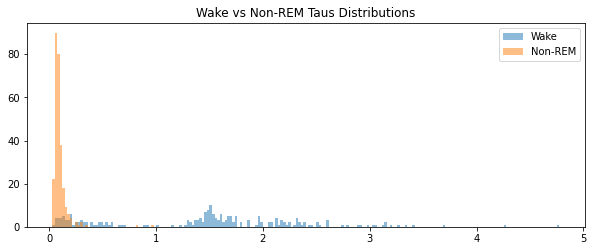

In [10]:
plot_tau_dist(wake_taus, nrem_taus)

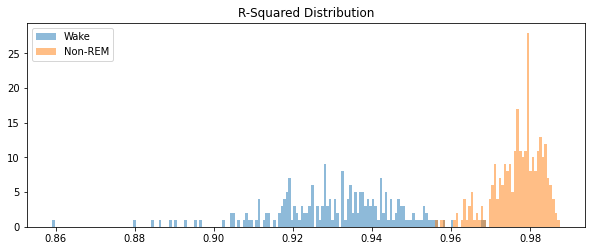

In [11]:
plot_rsq_dist(wake_rsq, nrem_rsq)

## Comparison to ACF

In [12]:
# SpecParam
knee_freqs = np.zeros(len(win_starts))
knee_taus = np.zeros(len(win_starts))


with Pool(processes=8) as pool:

    mapping = pool.imap(partial(_fit_acf, sig_lfp=sig_lfp, fs=fs, win_len=win_len), 
                        win_starts, chunksize=100)
    
    results = list(tqdm(mapping, total=len(win_starts), dynamic_ncols=True))
    
taus_acf = np.array([i[0] for i in results])
rsq_acf = np.array([i[1] for i in results])

  0%|          | 0/616 [00:00<?, ?it/s]

In [13]:
_taus, _rsqs = sort_taus(sig_lfp, rem, nrem, wake, mids, taus_acf, rsq_acf)

wake_taus_acf, rem_taus_acf, nrem_taus_acf = _taus
wake_rsq_acf, rem_rsq_acf, nrem_rsq_acf = _rsqs

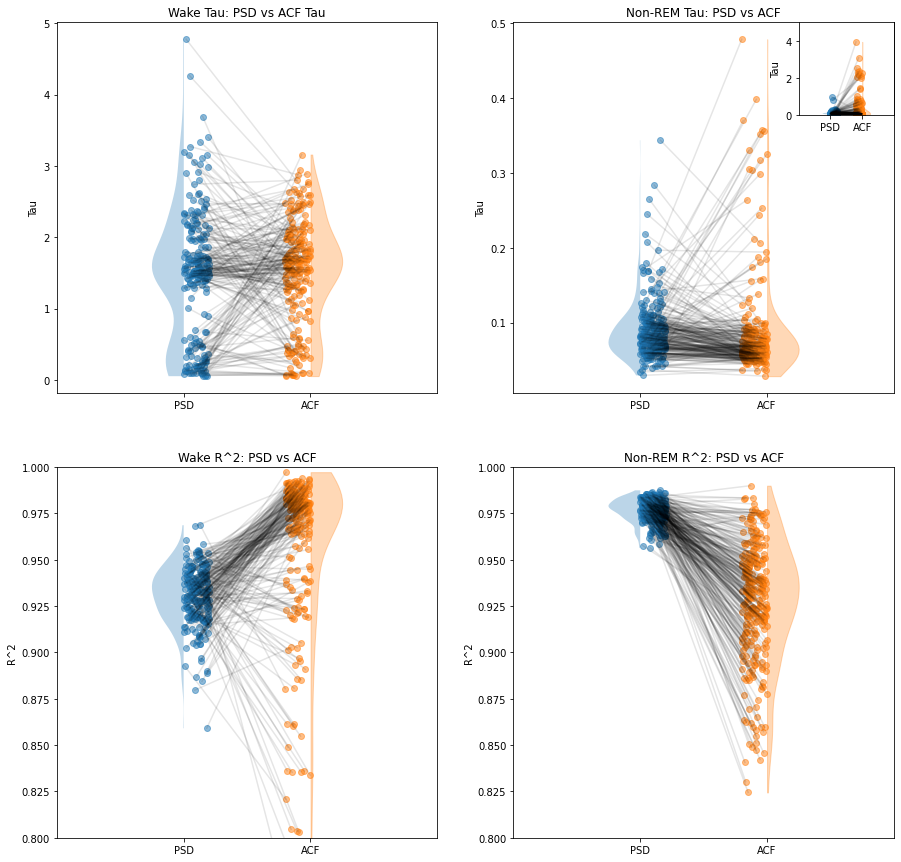

In [14]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(15, 15))

plot_connected_scatter(wake_taus, wake_taus_acf, axes[0][0], title='Wake Tau: PSD vs ACF Tau')

inds = np.where((nrem_taus<=.5) & (nrem_taus_acf<=.5))
plot_connected_scatter(nrem_taus[inds], nrem_taus_acf[inds], axes[0][1], 'Non-REM Tau: PSD vs ACF')

axins = axes[0][1].inset_axes([.75, .75, 0.25, 0.25])
plot_connected_scatter(nrem_taus, nrem_taus_acf, axins, title='', ylim=(0, 5))



plot_connected_scatter(wake_rsq, wake_rsq_acf, axes[1][0], title='Wake R^2: PSD vs ACF',
                       ylim=(.8, 1), ylabel='R^2')
plot_connected_scatter(nrem_rsq, nrem_rsq_acf, axes[1][1], title='Non-REM R^2: PSD vs ACF',
                       ylim=(.8, 1), ylabel='R^2')